In [1]:
import numpy as np 
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import regex as re

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
%pip install -U huggingface_hub
import os
import random
import glob
from torch import no_grad
import torch.nn as nn
from torch import tensor
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import f1_score
import spacy
!python -m spacy download en_core_web_md 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.16.4
    Uninstalling huggingface-hub-0.16.4:
      Successfully uninstalled huggingface-hub-0.16.4
Note: you may need to restart the kernel to use updated packages.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefine

In [2]:
train_file = "/kaggle/input/nlp-getting-started/train.csv"
test_file = "/kaggle/input/nlp-getting-started/test.csv"

In [3]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data Preprocessing

In [6]:
def find_dupe(dataframe):
# find duplicate rows based on the "text" column
    duplicate_rows = train_df[train_df.duplicated(subset='text', keep=False)]

    duplicates_df = pd.DataFrame(columns=train_df.columns)

    for index, row in duplicate_rows.iterrows():
        duplicates_df = duplicates_df.append(row, ignore_index=True)

    return(duplicates_df)

In [7]:
train_dupe = find_dupe(train_df)

/tmp/ipykernel_28/134327030.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  duplicates_df = duplicates_df.append(row, ignore_index=True)


In [8]:
#file_path = '/kaggle/working/duplicate.csv'
# train_dupe.to_csv(file_path, index=False) 

In [9]:
train_df.drop_duplicates(subset='text', inplace=True)

In [10]:
check_dupe = find_dupe(train_df) 
print(check_dupe)

Empty DataFrame
Columns: [id, keyword, location, text, target]
Index: []


In [11]:
# There are 18 unique tweets in training set which are labeled differently in their duplicates.
# deal with the inconsistencies in target values
train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target'] = 0
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target'] = 0
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target'] = 1
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target'] = 1
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target'] = 1
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target'] = 0
train_df.loc[train_df['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target'] = 0
train_df.loc[train_df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target'] = 0
train_df.loc[train_df['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target'] = 0
train_df.loc[train_df['text'] == "Caution: breathing may be hazardous to your health.", 'target'] = 1
train_df.loc[train_df['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target'] = 0
train_df.loc[train_df['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target'] = 0
train_df.loc[train_df['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target'] = 0

In [12]:
#  pre-trained GloVe embeddings
nlp = spacy.load("en_core_web_md")

def detect_typos(tweet_text):
    doc = nlp(tweet_text)
    typos = []

    for token in doc:
        if not token.has_vector:  # Check if the word is in the GloVe vocabulary
            typos.append(token.text)

    return typos


def correct_typos(tweet_text):
    typos = detect_typos(tweet_text)
    corrected_text = tweet_text

    for typo in typos:
        similar_words = nlp.vocab.vectors.most_similar(nlp.vocab[typo].vector.reshape(1, -1), n=1)
        if similar_words:
            corrected_word = nlp.vocab.strings[similar_words[0][0]]
            corrected_text = corrected_text.replace(typo, corrected_word)

    return corrected_text



In [13]:
train_df['corrected_tweet'] = train_df['text'].apply(correct_typos)

In [14]:
nltk.download('stopwords')
nltk.download('punkt')

def clean_tweet_text(tweet):
    # convert to lowercase
    tweet = tweet.lower()
    
    # remove HTML tags using Beautiful Soup
    tweet = BeautifulSoup(tweet, "html.parser").get_text()
    
    # remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = tweet.replace("skea", "")
    
    # remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)

    # remove the "#" symbol from hashtags, keeping the content
    tweet = re.sub(r'#(\w+)', r'\1', tweet)

    # remove emojis 
    tweet = re.sub(r'\p{Emoji}', '', tweet)
    
    # remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # tokenize the tweet
    tokens = word_tokenize(tweet)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # join tokens back into a cleaned tweet
    cleaned_tweet = ' '.join(filtered_tokens)
    
    return cleaned_tweet



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
train_df['cleaned_tweet'] = train_df['corrected_tweet'].apply(clean_tweet_text)

/tmp/ipykernel_28/2159540967.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, "html.parser").get_text()


In [16]:
train_df.head()

,id,keyword,location,text,target,corrected_tweet,cleaned_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


In [17]:
sentences = train_df.cleaned_tweet.values
labels = train_df.target.values
print(len(sentences))
print(len(labels))

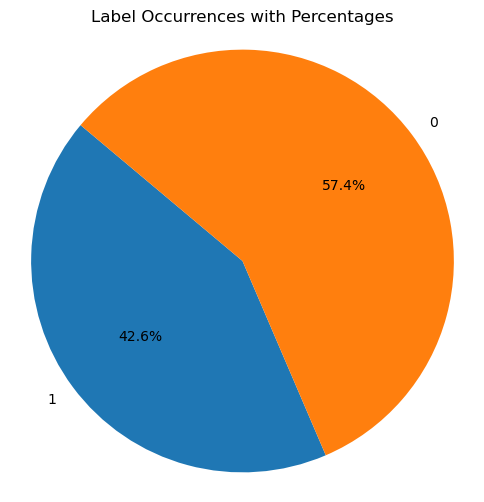

In [20]:
label_counts = Counter(labels)

# Plotting a pie chart
label_name = label_counts.keys()
sizes = label_counts.values()
total_items = sum(sizes)
percentages = [(count / total_items) * 100 for count in sizes]

plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=label_name, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Label Occurrences with Percentages")
plt.show()

In [21]:
# Split data into train and validation sets
train_tweets, val_tweets, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [33]:
print(len(val_tweets))
print(len(val_labels))

1501
1501


In [24]:
del train_df

## Loading BERT Tokenizer and Model

In [25]:
# random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [26]:
# load a pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
train_tweets = [str(tweet) for tweet in train_tweets]
val_tweets = [str(tweet) for tweet in val_tweets]

# tokenize the text data
train_inputs = tokenizer(train_tweets, padding=True, truncation=True, return_tensors="pt")
val_inputs = tokenizer(val_tweets, padding=True, truncation=True, return_tensors="pt")

# convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.float32)

# create DataLoader for training and validation sets
train_dataset = TensorDataset(train_inputs.input_ids, train_inputs.attention_mask, train_labels)
val_dataset = TensorDataset(val_inputs.input_ids, val_inputs.attention_mask, val_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# define optimizer and loss function
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss()

# training loop
num_epochs = 4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [27]:
for epoch in range(num_epochs):
    bert_model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(train_loader)}")
    print()

Epoch 1/4
Train Loss: 0.514313889627761

Epoch 2/4
Train Loss: 0.38644180082260293

Epoch 3/4
Train Loss: 0.3138440176844597

Epoch 4/4
Train Loss: 0.2402948871889013



In [28]:
# evaluation on the test set
bert_model.eval()
test_loss = 0.0
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1), labels)
        test_loss += loss.item()
        test_predictions.extend(torch.sigmoid(logits).cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# calculate test accuracy
test_predictions = np.array(test_predictions) > 0.5
test_f1_score = f1_score(test_true_labels, test_predictions)

print(f"Test Loss: {test_loss / len(val_loader)}")
print(f"Test F1 Score: {test_f1_score * 100:.2f}%")

Test Loss: 0.5035064704716206
Test F1 Score: 77.03%


In [29]:
def predict_disaster(text):

    cleaned_text = clean_tweet_text(text)
    inputs = tokenizer(cleaned_text, padding=True, truncation=True, return_tensors="pt")

    # forward pass through the model
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # get the logits from the model's output
    logits = outputs.logits

    
    prediction = torch.sigmoid(logits) > 0.5

    return prediction.item()  # returns 1 if it's a disaster, 0 if it's not

# example usage:
input_text = "#WildfireAlert🔥: Evacuations ordered as a fast-spreading wildfire threatens homes in the area. Stay safe and follow local authorities' instructions!"
result = predict_disaster(input_text)
if result == 1:
    print("It's a disaster.")
else:
    print("It's not a disaster.")

It's a disaster.
